# Dynamic Fama–French three-factor model

Reference: 
1. Tsay, Analysis of Financial Time Series - 11.3.1: CAPM with Time-Varying Coefficients
2. Punales, Ana G.S., "Time-Varying Coefficient Models And The Kalman Filter : Applications To Hedge Funds" (2011). Theses and
dissertations. Paper 1657.

## 1. Get data from Tiingo

Securities selected: AMZN, JNJ

In [1]:
#import pandas_datareader.data as web

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm

tiingo_key = open('/Users/jenchiehcheng/tiingo/tiingo_key.txt').read()

start = datetime.datetime(2009, 12, 31)
end = datetime.datetime(2018, 2, 28)

%matplotlib inline

/Users/jenchiehcheng/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
tickers = ['AMZN', 'JNJ']

px = pdr.DataReader(tickers, data_source='tiingo', start=start, end=end, access_key=tiingo_key)

close_px = pd.concat([px.loc[ticker, 'adjClose'] for ticker in tickers], axis=1)
close_px.columns = tickers

ret = close_px.pct_change()

In [3]:
FF = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=start, end=end)
FF[0] = FF[0] / 100
print(FF[0].columns)
rm = FF[0]['Mkt-RF']
rf = FF[0]['RF']

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


In [4]:
# excess returns
re = pd.concat([FF[0]] + [ret[ticker] - rf for ticker in tickers], axis=1)
re.columns = FF[0].columns.tolist() + tickers
re.dropna(inplace=True)
re.head()

,Mkt-RF,SMB,HML,RF,AMZN,JNJ
2010-01-04,0.0169,0.0058,0.0112,0.0,-0.004609,0.004192
2010-01-05,0.0031,-0.0059,0.0122,0.0,0.005900,-0.011596
2010-01-06,0.0013,-0.0025,0.0052,0.0,-0.018116,0.008134
2010-01-07,0.0040,0.0008,0.0094,0.0,-0.017013,-0.007137
2010-01-08,0.0033,0.0040,0.0001,0.0,0.027077,0.003438


## 2. Kalman filter: FF-3 factor with state space model

Systematic factor: $F_t \in \mathbb{R}^{k \times 1}$, $k=3$ in our model. Assume $\alpha, \beta_i$ are autoregressive of order 1.

$$
\begin{align}
r_t &= \alpha_t + \beta_t^\top F_t + e_t \\
\alpha_{t+1} &= \alpha_t + \eta_t \\
\beta_{t+1} &= \beta_t + \epsilon_t \\
\end{align}
$$

where $e_t \sim N(0, \sigma_e^2)$, $\eta_t \sim N(0, \sigma_\eta^2)$, and $\epsilon_t \sim N(0, \Sigma_\epsilon^2)$. $(\sigma_e, \sigma_\eta, \Sigma_\epsilon)$ is assumed to be known and independent.

Measurement equation:
$$
r_t = 
\begin{bmatrix}
1 & F_t
\end{bmatrix}
\begin{bmatrix}
\alpha_t \\
\beta_t \\
\end{bmatrix}
+e_t
$$

State equation:
$$
\begin{bmatrix}
\alpha_{t+1} \\
\beta_{t+1} \\
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 \\
0 & I_k\\
\end{bmatrix}
\begin{bmatrix}
\alpha_t \\
\beta_t \\
\end{bmatrix}
+
\begin{bmatrix}
\eta_t \\
\epsilon_t \\
\end{bmatrix}
$$

In [5]:
def generalized_KF_update(prev_S, prev_P, y, Z, sys_params):
    
    '''
    y: obervation values (r_t)
    Z: obervation model ([1, F_t] = [1, r_{1, t}, ..., r{k, t}])
    '''
    
    SST = sys_params['SST'] # I_{1+k}
    Q = sys_params['Q'] # diag matrix
    H = sys_params['H'] # variance of r - (a + b*rm)
    
    # === state prediction ===
    pred_S = SST.dot(prev_S)
    
    # === prediction dispersion ===
    pred_P = SST.dot(prev_P).dot(SST.T) + Q
    
    # === observation prediction ===
    pred_y = Z.dot(pred_S)
    
    # === prediction error ===
    pred_err = y - pred_y
    
    # === error dispersion ===
    F = Z.dot(pred_P).dot(Z.T) + H # assume 1 by 1
    
    # === kalman gain ===
    G = pred_P.dot(Z.T) / F
    
    # === state estimate ===
    est_S = pred_S + G.dot(pred_err)
    
    # === dispersion estimate ===
    est_P = pred_P - G.dot(Z).dot(pred_P)
    
    return est_S, est_P

In [6]:
def generalized_KF(obs_val, obs_model, init_state, init_dispersion, sys_params):
    
    assert(obs_val.shape[0] == obs_model.shape[0])
    N = obs_val.shape[0]
    k = len(init_state)
    
    S = np.array(init_state).reshape(k, 1)
    P = np.array(init_dispersion).reshape(k, k)
    #kf = np.array([init_state])
    kf = np.empty([N, k])
    
    o_val = obs_val.values
    o_model = obs_model.values
    
    for i in range(N):
        y = o_val[i]
        Z = o_model[i].reshape(1, k)
        
        S, P = generalized_KF_update(S, P, y, Z, sys_params)
        kf[i, :] = S.T
        
    return kf

In [7]:
def get_init_state_from_OLS(R, Rm):
    
    k = Rm.shape[1] + 1
    res = sm.OLS(R, sm.add_constant(Rm)).fit(cov_type='HC0')
    
    S = res.params
    P = np.zeros((k, k))
    
    sys_params = dict()
    sys_params['H'] = res.mse_model,
    sys_params['Q'] = np.diag(res.HC0_se.values)
    sys_params['SST'] = np.eye(k)

    return S, P, sys_params

In [8]:
# wrapper
def KF_FF3(ticker, data, factors=['Mkt-RF', 'SMB', 'HML'], N=100):
    
    train_df, test_df = data.iloc[:N], data[N:]
    S, P, sys_params = get_init_state_from_OLS(train_df[ticker], train_df[factors])
    kf = generalized_KF(test_df[ticker] , sm.add_constant(test_df[factors]), S, P, sys_params)
    kf = pd.DataFrame(kf, columns=['Alpha'] + factors, index=data.index[N:])
    
    return kf

# Comparison: KF v.s. OLS

1. Rolling Window OLS $(n=30, 100)$
2. Entire sample OLS

Measure in RMSE (root of mean square error).

In [9]:
def rolling_FF3(ticker, data, factors=['Mkt-RF', 'SMB', 'HML'], window=100):
    #(y, x, window=60):
    """ 
    y and x must be pandas.Series
    """
    
    assert(data.index.size > window)
    
    X = sm.add_constant(data[factors]).values
    Y = data[ticker].values
    b = pd.DataFrame(index=data.index[window:], columns=['Alpha'] + factors)
    
    for i in range(window, data.index.size):
        X_slice = X[i-window:i, :]
        Y_slice = Y[i-window:i]
        coeff = np.dot(np.dot(np.linalg.inv(np.dot(X_slice.T, X_slice)), X_slice.T), Y_slice)
        b.loc[data.index[i],:] = coeff
        
    return b 

def entire_sample_OLS(ticker, data, factors=['Mkt-RF', 'SMB', 'HML']):
    
    X = sm.add_constant(data[factors])
    X.columns = ['Alpha'] + factors
    res = sm.OLS(data[ticker], X).fit(cov_type='HC0')
    return res.params

In [10]:
def rmse(ticker, data, loading_est, factors=['Mkt-RF', 'SMB', 'HML']):
    
    if len(loading_est.shape) == 2:
        idx = loading_est.index
        pred = loading_est[factors].multiply(data.loc[idx, factors]).sum(axis=1) + loading_est['Alpha']
        err = pred - data.loc[idx, ticker]
    else:
        pred = data[factors].dot(loading_est[factors]) + loading_est['Alpha']
        err = pred - data[ticker]
    
    return np.mean(err**2) ** 0.5

## 3.1 JNJ

In [11]:
JNJ_KF = KF_FF3('JNJ', re)
JNJ_w90 = rolling_FF3('JNJ', re, window=90)
JNJ_w180 = rolling_FF3('JNJ', re, window=180)
JNJ_const = entire_sample_OLS('JNJ', re)

In [12]:
print('Kalman Filter: ', rmse('JNJ', re, JNJ_KF))
print('Rolling 90:    ', rmse('JNJ', re, JNJ_w90))
print('Rolling 180:   ', rmse('JNJ', re, JNJ_w180))
print('Entire:        ', rmse('JNJ', re, JNJ_const))

Kalman Filter:  0.003746065842044171
Rolling 90:     0.00664409787834
Rolling 180:    0.00658130615905
Entire:         0.006473239811934177


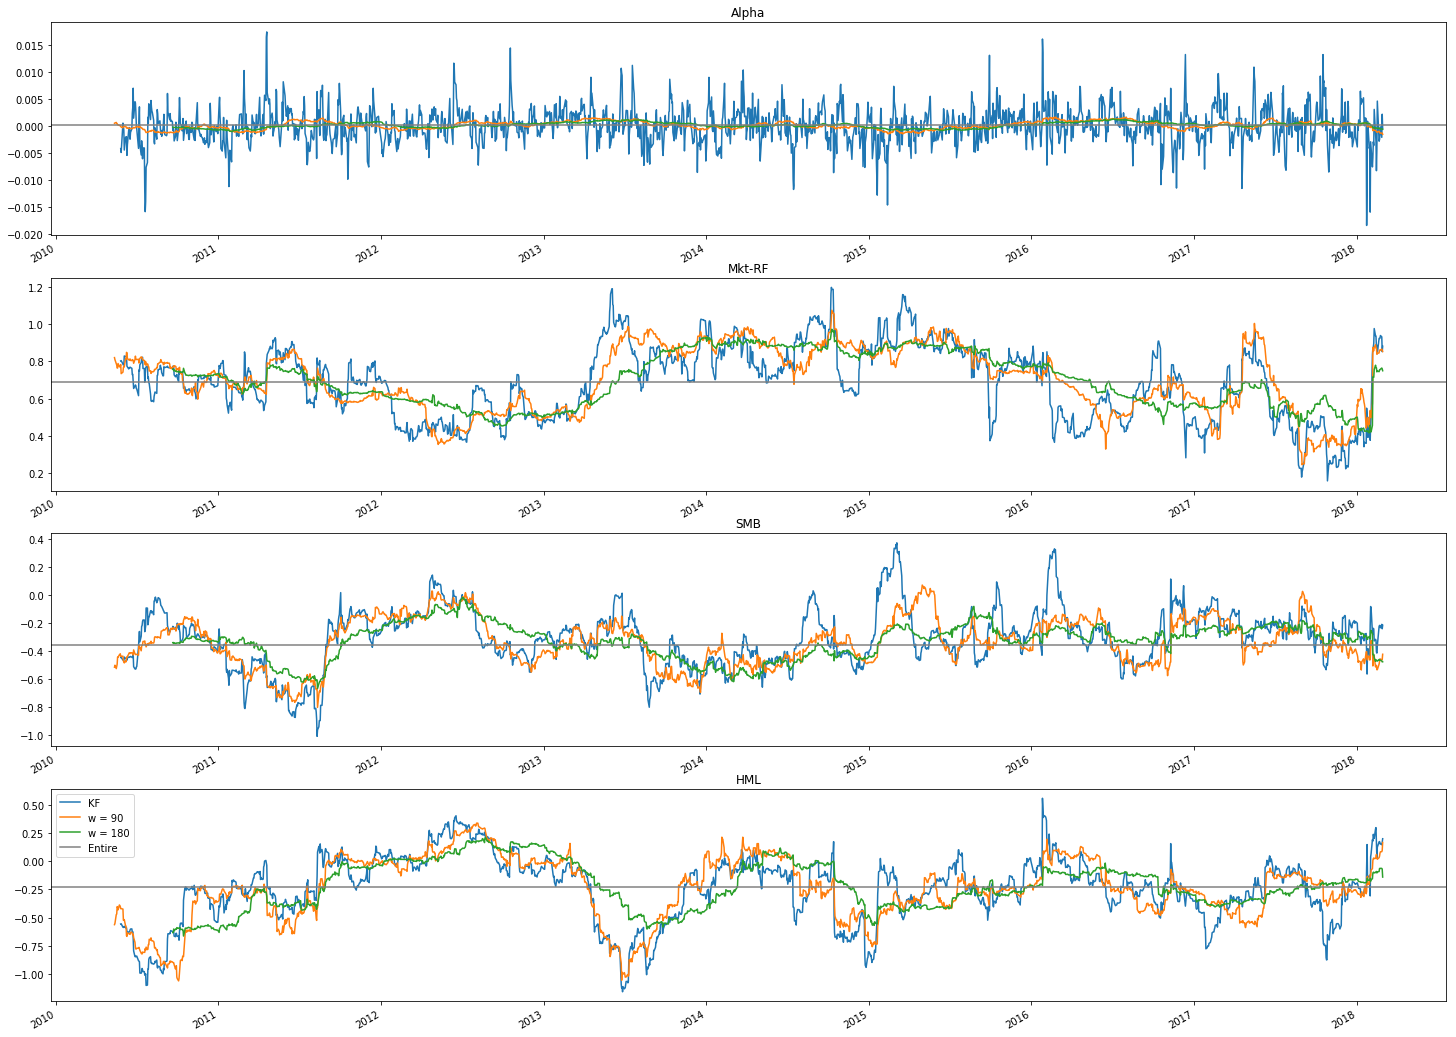

In [13]:
f, ax = plt.subplots(4, 1, figsize=(25,20))

for i, F in enumerate(['Alpha', 'Mkt-RF', 'SMB', 'HML']):
    JNJ_KF[F].plot(label='KF', ax=ax[i])
    JNJ_w90[F].plot(label='w = 90', ax=ax[i])
    JNJ_w180[F].plot(label='w = 180', ax=ax[i])
    ax[i].axhline(JNJ_const[F], c='gray', label='Entire')
    ax[i].set_title(F)

plt.legend()

### 3.2. AMZN

In [14]:
AMZN_KF = KF_FF3('AMZN', re)
AMZN_w90 = rolling_FF3('AMZN', re, window=90)
AMZN_w180 = rolling_FF3('AMZN', re, window=180)
AMZN_const = entire_sample_OLS('AMZN', re)

In [15]:
print('Kalman Filter: ', rmse('AMZN', re, AMZN_KF))
print('Rolling 90:    ', rmse('AMZN', re, AMZN_w90))
print('Rolling 180:   ', rmse('AMZN', re, AMZN_w180))
print('Entire:        ', rmse('AMZN', re, AMZN_const))

Kalman Filter:  0.008523134670045559
Rolling 90:     0.0161848234701
Rolling 180:    0.0161581029975
Entire:         0.016063229673708566


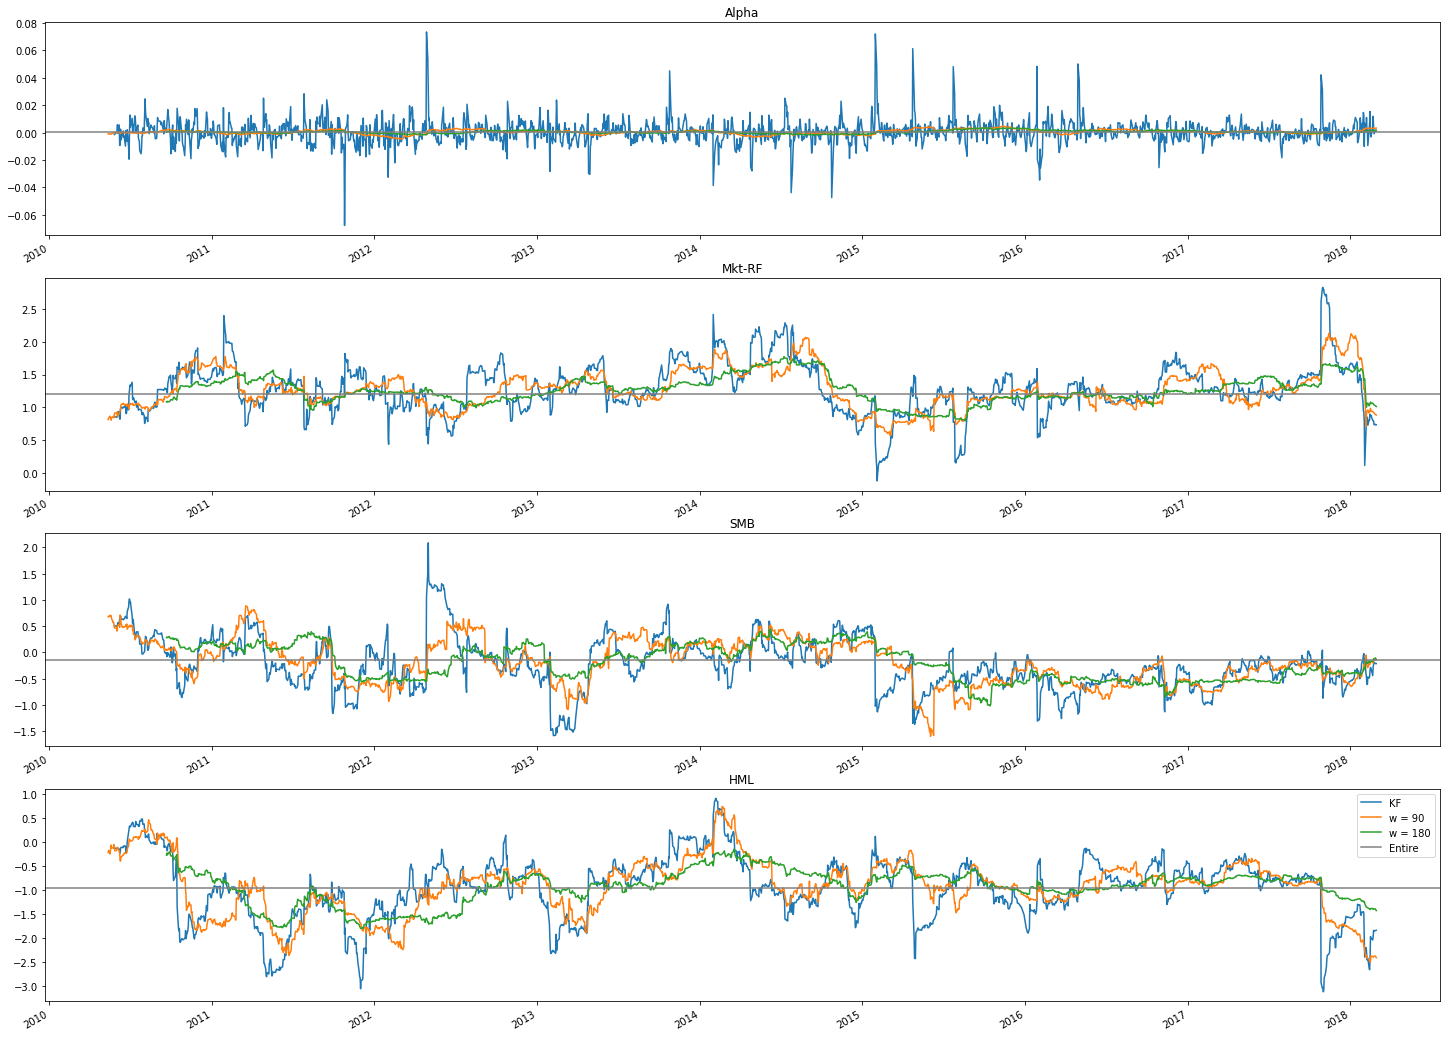

In [16]:
f, ax = plt.subplots(4, 1, figsize=(25,20))

for i, F in enumerate(['Alpha', 'Mkt-RF', 'SMB', 'HML']):
    AMZN_KF[F].plot(label='KF', ax=ax[i])
    AMZN_w90[F].plot(label='w = 90', ax=ax[i])
    AMZN_w180[F].plot(label='w = 180', ax=ax[i])
    ax[i].axhline(AMZN_const[F], c='gray', label='Entire')
    ax[i].set_title(F)

plt.legend()